In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
import pickle
import random
import pandas as pd
import tensorflow as tf

In [2]:
with open('german-traffic-signs/train.p','rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
    test_data = pickle.load(f)

In [3]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [4]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"

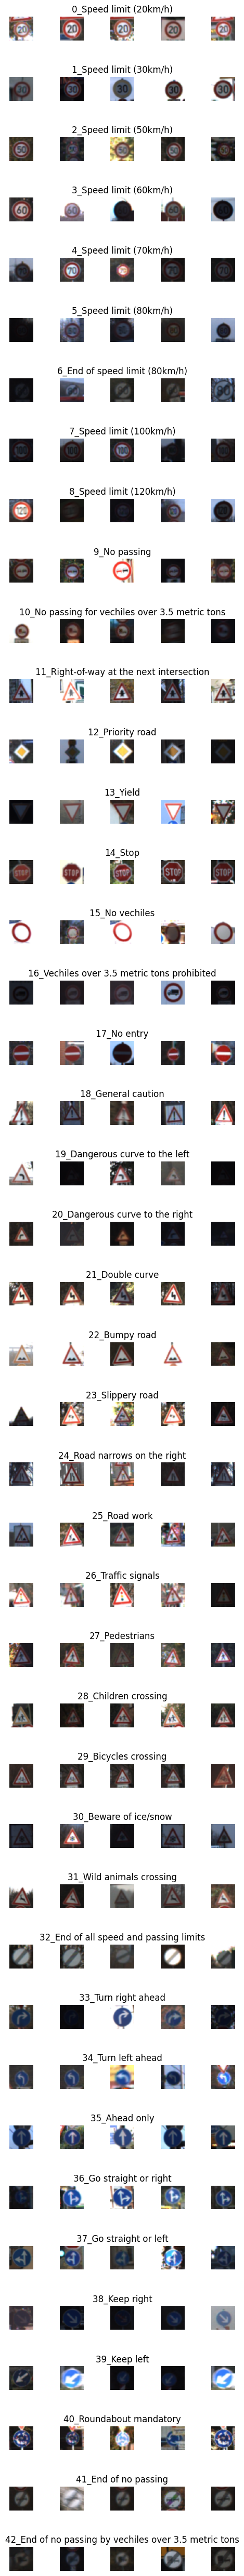

In [5]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []
cols = 5
num_classes = 43
fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))

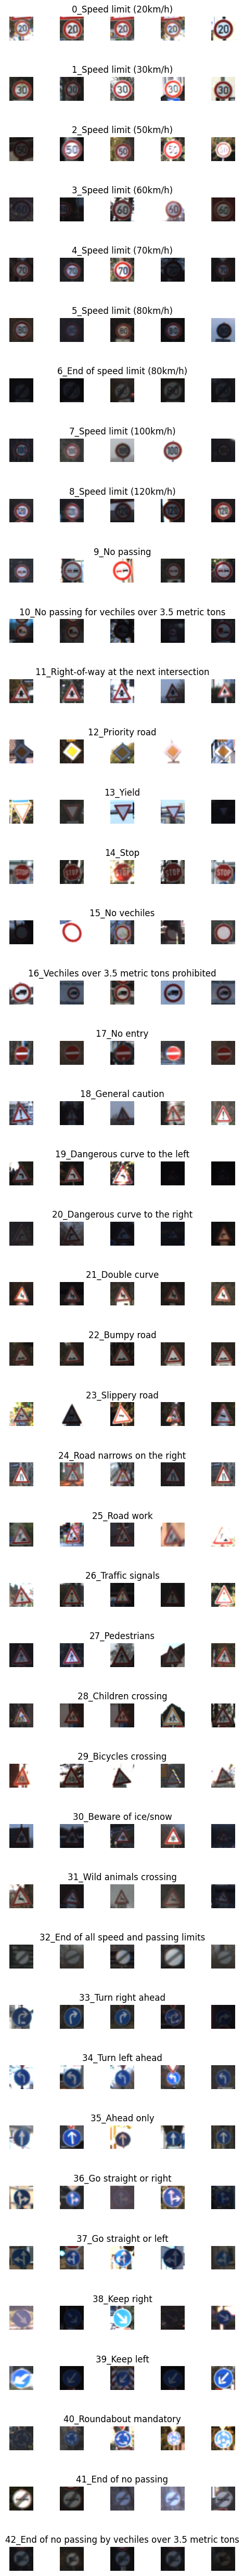

In [6]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []
cols = 5
num_classes = 43
fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))

In [7]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
def grayscale(img):
    if len(img.shape) == 3:  # Check if the image is not already grayscale
        image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        image = img  # If already grayscale, no need to convert
    plt.axis('off')
    return image
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

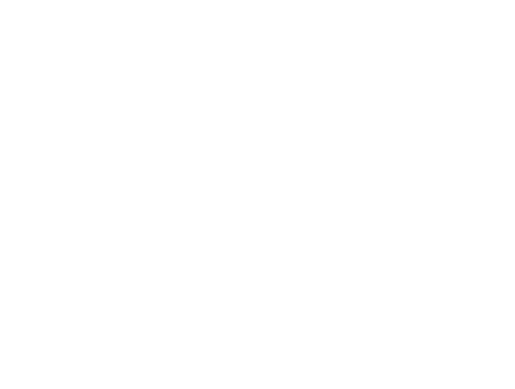

In [8]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [9]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                  height_shift_range = 0.1,
                   zoom_range = 0.2,
                  shear_range = 0.1,
                  rotation_range = 10)

datagen.fit(X_train)

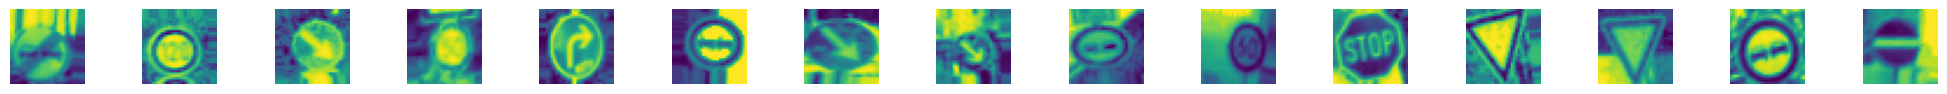

In [11]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [12]:
x_train=X_train
y_train=y_train
X_test=X_test
y_test=y_test
min_ = np.min(x_train)
max_ = np.max(x_train)

## Introduction

In this notebook we will look at inference attacks against an MNIST classifier.
Specifically, we will use the ART implementation of Fredrikson et al.'s (2015) MI-Face algorithm.

In [13]:
import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
from numpy.random import seed
seed(123)

from art.estimators.classification import KerasClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace
from art.utils import load_dataset

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

### Train model and initialize attack

In [14]:
# create standard CNN in Keras and wrap with ART KerasClassifier:
def cnn_mnist(input_shape, min_val, max_val):
  
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    classifier = KerasClassifier(clip_values=(min_val, max_val), 
                                model=model, use_logits=False)
    return classifier

In [15]:
num_epochs = 10

# Construct and train a convolutional neural network
classifier = cnn_mnist(x_train.shape[1:], min_, max_)
classifier.fit(x_train, y_train, nb_epochs=num_epochs, batch_size=100)

In [16]:
# Create the attack.
# Note: by setting the threshold to 1., the attack will effectively exhaust the maximum number of iterations.

attack = MIFace(classifier, max_iter=10000, threshold=1.) 

In [17]:
# Our attack target in the following will be to infer information about the training samples 
# for each of the 10 MNIST CLASSES:

y = np.arange(10)

In [34]:
# We will experiment with a number of different initializations:

x_init_white = np.zeros((10, 32, 32, 1))
x_init_grey = np.zeros((10, 32, 32, 1)) + 0.5
x_init_black = np.ones((10, 32, 32, 1))
x_init_random = np.random.uniform(0, 1, (10, 32, 32, 1))
x_init_average = np.zeros((10, 32, 32, 1)) + np.mean(X_test, axis=0)

### Initialization with white image

In [23]:
# We observe that the classifier's gradients are vanishing on white images, therefore the attack won't work:

print("Maximum class gradient: %f" % (np.max(np.abs(classifier.class_gradient(x_init_white, y)))))

Maximum class gradient: 0.090172


### Initialization with grey image

In [25]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_grey, y)
class_gradient = np.reshape(class_gradient, (10, 32*32))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.000000


In [26]:
%%time

# Now we run the attack:
x_infer_from_grey = attack.infer(x_init_grey, y)

Model inversion: 100%|██████████| 10/10 [09:08<00:00, 54.86s/it]

CPU times: total: 1min 27s
Wall time: 9min 8s


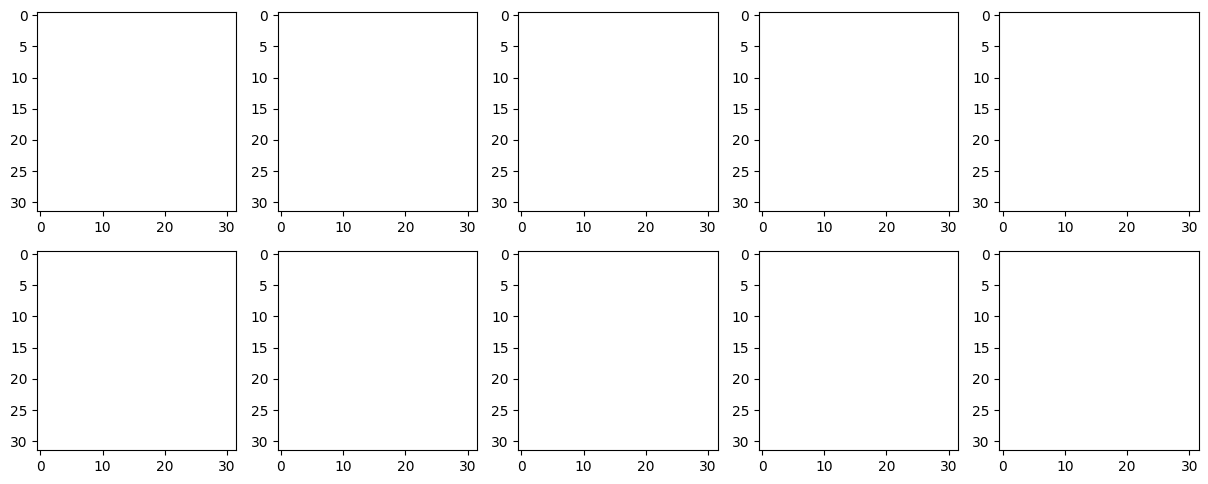

In [28]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_grey[0+i,], (32, 32))), cmap=plt.cm.gray_r)

As we can see, the attack reveals certain structural properties of the training instances for each 
of the ten classes.

### Initialization with black image

In [30]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_black, y)
class_gradient = np.reshape(class_gradient, (10, 32*32))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.000000


In [31]:
%%time

# Now we run the attack:
x_infer_from_black = attack.infer(x_init_black, y)

Model inversion: 100%|██████████| 10/10 [08:57<00:00, 53.78s/it]

CPU times: total: 1min 25s
Wall time: 8min 57s


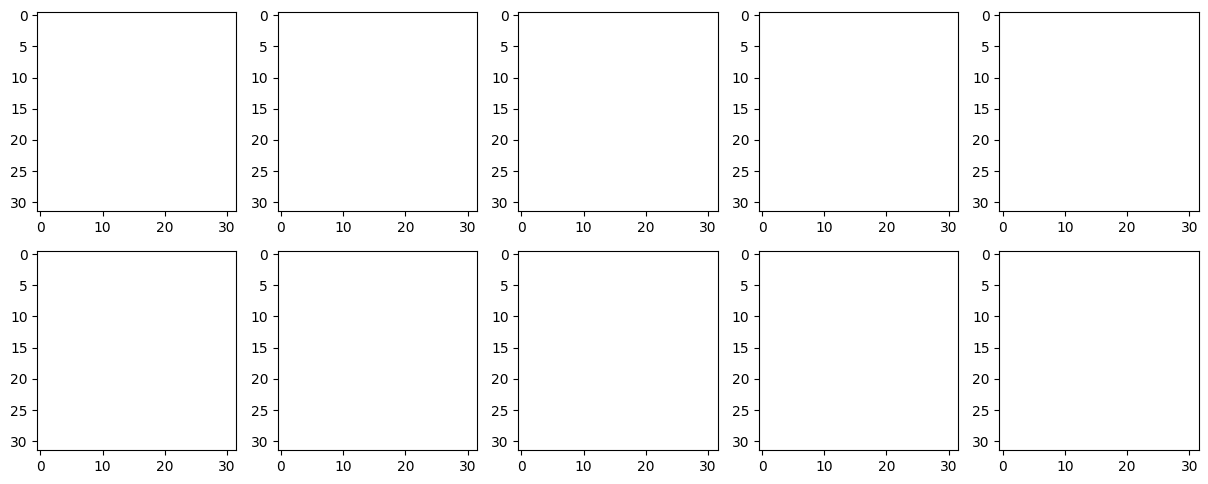

In [35]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_black[0+i,], (32, 32))), cmap=plt.cm.gray_r)

### Initialization with random image

In [37]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_random, y)
class_gradient = np.reshape(class_gradient, (10, 32*32))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.000001


In [38]:
%%time

# Now we run the attack:
x_infer_from_random = attack.infer(x_init_random, y)

Model inversion: 100%|██████████| 10/10 [09:53<00:00, 59.38s/it]

CPU times: total: 1min 33s
Wall time: 9min 53s


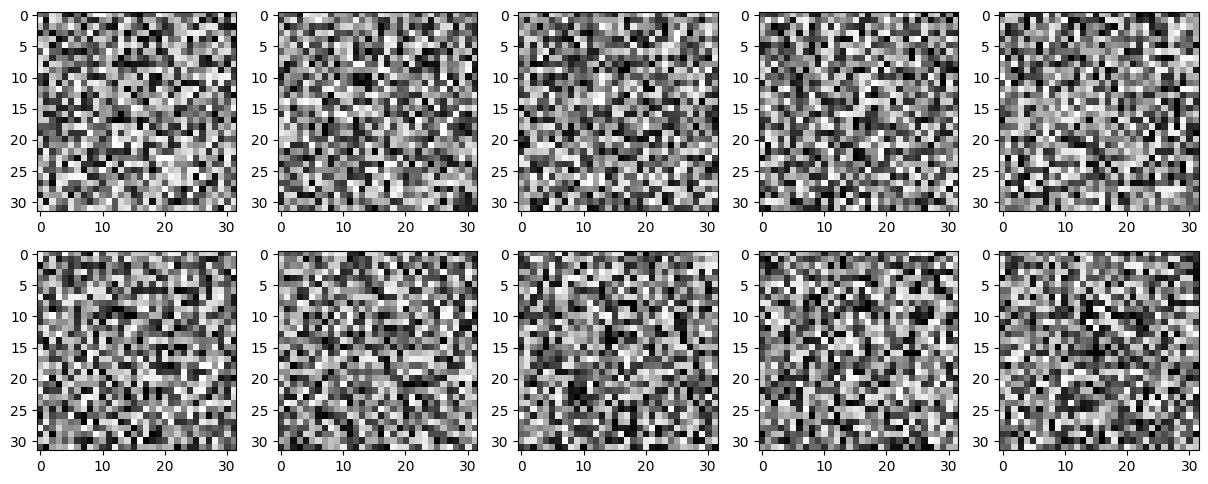

In [39]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_random[0+i,], (32, 32))), cmap=plt.cm.gray_r)

### Initialization with average image

In [40]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_average, y)
class_gradient = np.reshape(class_gradient, (10, 32*32))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.000004


In [41]:
%%time

# Now we run the attack:
x_infer_from_average = attack.infer(x_init_average, y)

Model inversion: 100%|██████████| 10/10 [08:57<00:00, 53.80s/it]

CPU times: total: 1min 24s
Wall time: 8min 57s


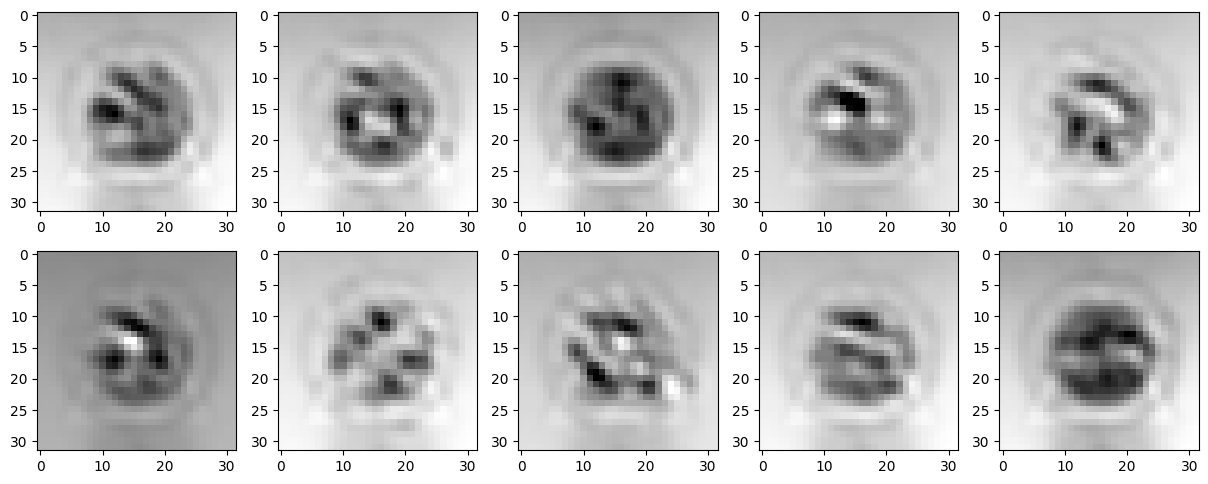

In [42]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_average[0+i,], (32, 32))), cmap=plt.cm.gray_r)